# LAMA into the Wild Part1: DataPreperation

# Overview

In this section We will preprocess the Data that we needed in the whole program. The result will be stored in `../data/pre`

In [12]:
import os
import gc
import typing as t
import logging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data import DATA_DIR
from lama.util import to_tuple, identity
from lama.util.decorators import enable_logging
from lama.util.StreamerBuilder import StreamerBuilder
from lama.preprocessing.DataProcessor import nans, change_object_col, reformat_dataframe, split_with_index, standarize_col

# 1.1 Define Global Constants

To make our reading and writing more easier, we decide to define some global constants below, you can change them if you'd like to write to another location.

In [13]:
OUT_DIR = os.path.join(DATA_DIR, "pre")
logger = logging.getLogger('root')

The process looks alike, we will handle them one by one.

- filter out Nan values
- check unique columns
- convert object values to numericals
- catagorize discrete and continous features
- scaling columns with Standardizer or Normalizer. 

# Train and Test

We will first handle train and test dataset.

In [14]:
df_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), header=0)
df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), header=0)

* check nans

In [15]:
# check nans
print(f'df_test nans: \n{nans(df_test)}\n')
print(f'df_train nans: \n{nans(df_train)}\n')

df_test_copy = df_test.copy()

df_test nans: 
first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

df_train nans: 
first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64



Before we go on to next section. lets check if there is abnormal distribution in train dataset.

In [16]:
sns.histplot(df_train['target'], kde=True).set(title="HistPlot of Train Target")
unexpected = (df_train['target'] < -30).sum()
print(f'unexpected value: {unexpected}')

unexpected value: 2207


Clearly there exists some unexpected values when target < -30.


One more thing to notice is the distributiton is symmetric to 0. 

In [17]:
df_train_copy = df_train[df_train['target'] > -30]
sns.histplot(df_train_copy['target'], kde=True).set(title="HistPlot of Train Target")

[Text(0.5, 1.0, 'HistPlot of Train Target')]

then we check if the id is unique, this procedure is important as we might need to outer join other datasets with id. 

In [18]:
train_count = df_train_copy.shape[0]
test_count = df_test_copy.shape[0]
print(df_train_copy['card_id'].nunique() == train_count)
print(df_test_copy['card_id'].nunique() == test_count)

True
True


In [19]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199710 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   first_active_month  199710 non-null  object 
 1   card_id             199710 non-null  object 
 2   feature_1           199710 non-null  int64  
 3   feature_2           199710 non-null  int64  
 4   feature_3           199710 non-null  int64  
 5   target              199710 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 10.7+ MB


Now we have to convert obejct to numeric values, as we seen above, there are two object values, since the card_id is a foreign key bound to match more features in other dataset, we'll leave it intact. 

In [20]:

features = ['first_active_month']
df_temps = reformat_dataframe(df_test_copy.append(df_train_copy), features, change_object_col)
df_test_copy, df_train_copy = to_tuple(split_with_index(df_temps, test_count))
del df_temps

After change the columns we would like to see if the train and test features are evenly splitted.

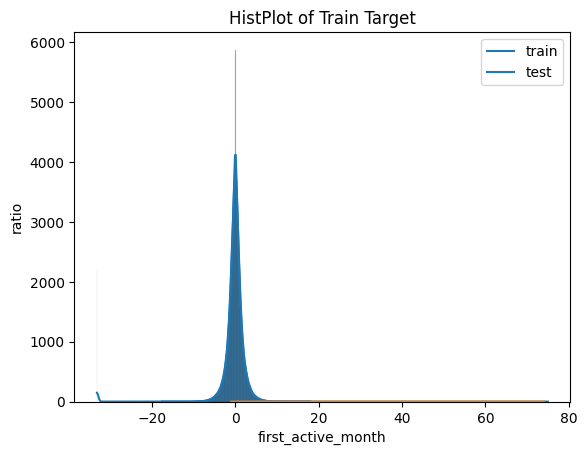

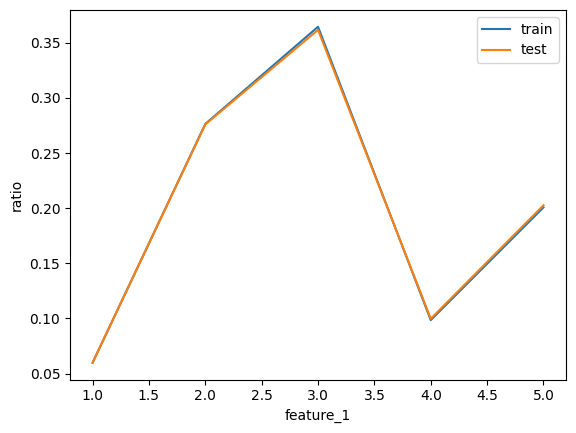

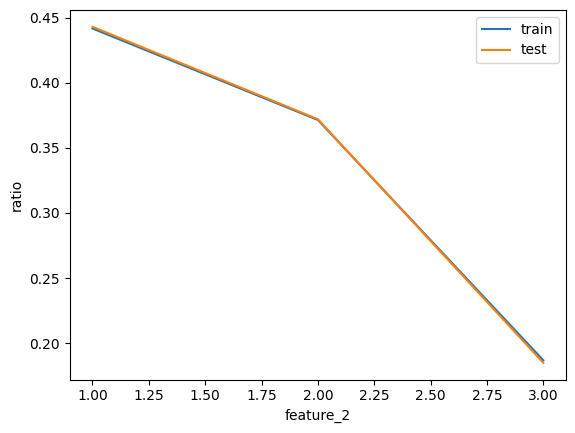

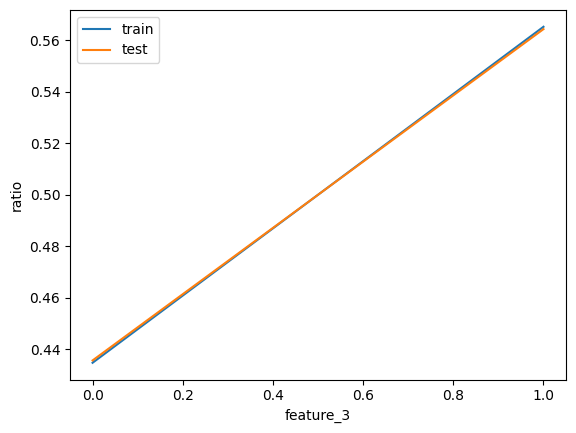

In [21]:
features = ['first_active_month', 'feature_1', 'feature_2', 'feature_3']
for feature in features:
    (df_train_copy[feature].value_counts().sort_index() / train_count).plot()
    (df_test_copy[feature].value_counts().sort_index() / test_count).plot()
    plt.legend(['train', 'test'])
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.show()

Now we need to standarize the features, since not every model need standarized data, we will just leave the builder here uncollected.  

In [22]:
builder = StreamerBuilder.build([df_test_copy, df_train_copy]) \
    .map(lambda df: reformat_dataframe(df, features, standarize_col))

Last step is to write the result back, and fetch when we needed.

In [23]:
df_test_copy.to_csv(os.path.join(OUT_DIR, 'test_pre.csv'), index=False)
df_train_copy.to_csv(os.path.join(OUT_DIR, 'train_pre.csv'), index=False)

del df_test, df_test_copy, df_train, df_train_copy, features, test_count, train_count, unexpected


# Merchant Data purge

Now we will hava a look at merchants.csv

In [24]:
df_merchant = pd.read_csv(os.path.join(DATA_DIR, 'merchants.csv'), header=0)
df_merchant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

In [25]:
print (df_merchant.shape[0], df_merchant['merchant_id'].nunique())
nans(df_merchant)


334696 334633


merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

Obviously, there exists some merchant whose id appears multiple times in this dataset. In catagory_2 lacks a significant amount of datas. We will check the unique value from category 4 to see if it is possible to repace nans to 0

We will change the object columns to numerical ones.

In [26]:


merchants_category_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id',
                 'subsector_id', 'category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'city_id', 'state_id', 'category_4', 'category_2']

merchants_numeric_cols = ['numerical_1', 'numerical_2', 'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
                'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12']

assert len(merchants_numeric_cols) + len(merchants_category_cols) == len(df_merchant.columns)

check category columns unique values

In [27]:
df_merchant[merchants_category_cols].nunique()
df_merchant[merchants_category_cols].dtypes
df_merchant['category_2'] .unique()
df_merchant['category_2'].fillna(-1, inplace=True)
cols = ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']
df_merchant = reformat_dataframe(df_merchant, cols, change_object_col)
print(df_merchant[df_merchant['category_2'] == -1])

            merchant_id  merchant_group_id  merchant_category_id  \
3       M_ID_a70e9c5f81               5026                   792   
4       M_ID_64456c37ce               2228                   222   
7       M_ID_d8ff08219e              16430                   529   
9       M_ID_d2162ed113             112122                    81   
11      M_ID_73487fed26              17123                   427   
...                 ...                ...                   ...   
334686  M_ID_3111c6df35             107283                   690   
334688  M_ID_59764e8cb1              17285                   309   
334690  M_ID_a9d91682ad                 35                   241   
334692  M_ID_725a60d404                 35                   544   
334694  M_ID_9139332ccc                 35                   511   

        subsector_id  numerical_1  numerical_2  category_1  \
3                  9    -0.057471    -0.057471           1   
4                 21    -0.057471    -0.057471           1 

In [28]:
df_merchant[merchants_numeric_cols].dtypes
nans(df_merchant)
df_merchant.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,3.346960e+05,...,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,0.021031,3.388233,3.382565,13.832993,inf,...,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335,0.287126,102.917926,11.860942,2.259958
std,31623.043426,252.898046,9.807371,1.098154,1.070497,0.143488,0.753297,0.752935,2395.489999,NaN,...,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138,0.452422,107.090673,6.176889,1.657263
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,0.000000,0.000000,0.000000,-82.130000,3.334953e-01,...,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.000000,3.000000,3.000000,0.880000,9.236499e-01,...,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000,0.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,0.000000,4.000000,4.000000,1.000000,1.016667e+00,...,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000,0.000000,69.000000,9.000000,1.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,0.000000,4.000000,4.000000,1.160000,1.146522e+00,...,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000,1.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,1.000000,4.000000,4.000000,851844.640000,inf,...,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000,1.000000,347.000000,24.000000,5.000000


In [29]:
inf_cols = ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']

# replace infinity with second largest values
df_merchant = reformat_dataframe(df_merchant, inf_cols, lambda df: df.replace(np.inf, df[df != np.inf].max()))
df_merchant.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,334696.000000,...,3.346830e+05,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,0.021031,3.388233,3.382565,13.832993,2.145143,...,2.165079e+01,2.390194,5.947397,2.522771e+01,2.529277,11.599335,0.287126,102.917926,11.860942,2.259958
std,31623.043426,252.898046,9.807371,1.098154,1.070497,0.143488,0.753297,0.752935,2395.489999,213.955844,...,3.947108e+03,194.324264,0.394936,5.251842e+03,174.419034,1.520138,0.452422,107.090673,6.176889,1.657263
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,0.000000,0.000000,0.000000,-82.130000,0.333495,...,-8.213000e+01,0.167045,1.000000,-8.213000e+01,0.098330,1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.000000,3.000000,3.000000,0.880000,0.923650,...,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000,0.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,0.000000,4.000000,4.000000,1.000000,1.016667,...,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000,0.000000,69.000000,9.000000,1.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,0.000000,4.000000,4.000000,1.160000,1.146522,...,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000,1.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,1.000000,4.000000,4.000000,851844.640000,61851.333333,...,1.513959e+06,56077.500000,6.000000,2.567408e+06,50215.555556,12.000000,1.000000,347.000000,24.000000,5.000000


Fill nans with mean values

In [30]:
df_merchant = reformat_dataframe(df_merchant, merchants_numeric_cols, lambda df: df.fillna(df.mean()))

nans(df_merchant)


merchant_id                    0
merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
city_id                        0
state_id                       0
category_2                     0
dtype: int64

# History Transaction and New Merchant Transaction Data Purge

These two datasets will be purged all together bacause they are highly relevant. In order to process the datasets efficiently we will use a StreamerBuilder to process the data chunk by chunk

In [31]:

chunksize=10 ** 6

def histories_builder() -> StreamerBuilder[pd.DataFrame] :
    return StreamerBuilder.build(pd.read_csv(os.path.join(DATA_DIR, "historical_transactions.csv"),
                       chunksize=chunksize))

def append_df(df1, df2):
    return df1.append(df2)

def sum_df(df1, df2):
    return df1.add(df2)

df_new_merchants = pd.read_csv(os.path.join(DATA_DIR, "new_merchant_transactions.csv"))
df_new_merchants.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB


We will firstly check the dulplciate columns

In [32]:
duplicate_cols = []

for col in df_new_merchants.columns:
    if col in df_merchant.columns:
        duplicate_cols.append(col)

duplicate_cols = ['merchant_id', 'city_id', 'category_1', 'merchant_category_id', 'category_2', 'state_id', 'subsector_id']
df_merchant = df_merchant.drop(duplicate_cols[1:], axis=1)
df_merchant = df_merchant.loc[df_merchant['merchant_id'].drop_duplicates().index]
df_merchant.to_csv(os.path.join(OUT_DIR, 'merchants_pre.csv'), index=False)

In [33]:
df_new_merchants[duplicate_cols].drop_duplicates().shape

(291242, 7)

We then merge merhcants_pre table to our transactions table

In [34]:
df_new_merchants['merchant_id'].nunique()
cols = ['most_recent_sales_range', 'most_recent_purchases_range', 'numerical_1', 'numerical_2', 'merchant_id']
df_new_merchants = df_new_merchants.merge(df_merchant[cols], how='left', on='merchant_id')

In [35]:
transactions_numeric = ['month_lag', 'installments', 'purchase_amount', 'numerical_1', 'numerical_2']
transactions_category = ['card_id', 'authorized_flag', 'category_3', 'category_1', 'merchant_category_id', 'subsector_id', 'merchant_id', 'city_id', "state_id", 'category_2', 'most_recent_sales_range', 'most_recent_purchases_range']
# reserved for time series model
transactions_time_cols = ['purchase_date']


assert len(df_new_merchants.columns) == len(transactions_category) + len(transactions_numeric) + len(transactions_time_cols)

In [36]:
df_new_merchants[transactions_category].dtypes

card_id                         object
authorized_flag                 object
category_3                      object
category_1                      object
merchant_category_id             int64
subsector_id                     int64
merchant_id                     object
city_id                          int64
state_id                         int64
category_2                     float64
most_recent_sales_range        float64
most_recent_purchases_range    float64
dtype: object

In [37]:
df_new_merchants[transactions_numeric].dtypes

month_lag            int64
installments         int64
purchase_amount    float64
numerical_1        float64
numerical_2        float64
dtype: object

In [38]:
nans(df_new_merchants)

authorized_flag                     0
card_id                             0
city_id                             0
category_1                          0
installments                        0
category_3                      55922
merchant_category_id                0
merchant_id                     26216
month_lag                           0
purchase_amount                     0
purchase_date                       0
category_2                     111745
state_id                            0
subsector_id                        0
most_recent_sales_range         26216
most_recent_purchases_range     26216
numerical_1                     26216
numerical_2                     26216
dtype: int64

In [39]:
features = ['authorized_flag', 'category_1', 'category_3']
df_new_merchants = reformat_dataframe(df_new_merchants, features, change_object_col)


# convert dtype to small int
df_new_merchants['category_2'].fillna(-1, inplace=True)
df_new_merchants['category_2'] = df_new_merchants['category_2'].astype(np.int8)
df_new_merchants['category_1'] = df_new_merchants['category_1'].astype(np.int8)
df_new_merchants['authorized_flag'] = df_new_merchants['authorized_flag'].astype(np.int8)
df_new_merchants['installments'] = df_new_merchants['installments'].astype(np.int8)
df_new_merchants['state_id'] = df_new_merchants['state_id'].astype(np.int8)
df_new_merchants['city_id'] = df_new_merchants['city_id'].astype(np.int8)
df_new_merchants['subsector_id'] = df_new_merchants['subsector_id'].astype(np.int8)

In [40]:
# convert purchase date to timeseries
datetime_index = pd.DatetimeIndex(df_new_merchants['purchase_date'])
df_new_merchants.info()
transactions_dtype = df_new_merchants.dtypes
df_new_merchants['purchase_day'] = datetime_index.day
df_new_merchants['purchase_month'] = datetime_index.month
df_new_merchants['purchase_year'] = datetime_index.year
df_new_merchants['purchase_hour_section'] = datetime_index.time

transactions_features = df_new_merchants.columns
transactions_path = os.path.join(OUT_DIR, 'transactions_pre.csv')
if os.path.exists(transactions_path):
    os.remove(transactions_path)
df_new_merchants.to_csv(transactions_path, mode='a', index=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963031 entries, 0 to 1963030
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   authorized_flag              int8   
 1   card_id                      object 
 2   city_id                      int8   
 3   category_1                   int8   
 4   installments                 int8   
 5   category_3                   int64  
 6   merchant_category_id         int64  
 7   merchant_id                  object 
 8   month_lag                    int64  
 9   purchase_amount              float64
 10  purchase_date                object 
 11  category_2                   int8   
 12  state_id                     int8   
 13  subsector_id                 int8   
 14  most_recent_sales_range      float64
 15  most_recent_purchases_range  float64
 16  numerical_1                  float64
 17  numerical_2                  float64
dtypes: float64(5), int64(3), int8(7), object(3

There is no need to fill numerical columns since they don't have nans

In [41]:
histories_nans = histories_builder().map(nans).reduce(sum_df).collect(identity)
print(histories_nans)

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64


In [42]:
# reserved for large memory write-ins
del df_new_merchants, datetime_index
gc.collect()

11058

As we can discover the history columns and new merchants columns are the same, so we can easily using the above methods again.

In [43]:
def add_datetime_index(df: pd.DataFrame):
    _datetime_index = pd.DatetimeIndex(df['purchase_date'])
    df['purchase_day'] = _datetime_index.day
    df['purchase_month'] = _datetime_index.month
    df['purchase_year'] = _datetime_index.year
    df['purchase_hour_section'] = _datetime_index.time
    return df

def convert_columns(df: pd.DataFrame):
    df['category_2'].fillna(-1, inplace=True)
    return df

to_csv_builder = histories_builder() \
                    .map(lambda df: reformat_dataframe(df, features, change_object_col)) \
                    .map(lambda df: df.merge(df_merchant[cols], how='left', on='merchant_id')) \
                    .map(convert_columns) \
                    .map(add_datetime_index)

# write to csv
to_csv_builder.consume(lambda df: df.to_csv(transactions_path, mode='a', index=False, header=False))

del to_csv_builder


# 1.2 Features Engineering

We will extract each columns by their numerical features and append them to the end

In [44]:
def create_aggs_cols() -> t.Tuple[t.Dict[str, str], t.List[str]]:
    aggs = {}
    for col in transactions_numeric:
        aggs[col] = ['nunique', 'mean', 'min', 'max', 'var', 'skew', 'sum']
    for col in transactions_category:
        aggs[col] = ['nunique']
    aggs['card_id'] = ['size', 'count']
    cols = []
    for key in aggs.keys():
        cols.extend([key+"_"+stat for stat in aggs[key]])
    return aggs, cols

In [45]:

@enable_logging("append_new_columns.log")
def append_new_columns(transaction, aggs, cols):
    df = transaction[transaction['month_lag'] < 0].groupby('card_id').agg(aggs)
    df.columns = [co + "_hist" for co in cols]
    df2 = transaction[transaction['month_lag'] >= 0].groupby('card_id').agg(aggs)
    df2.columns =[co + "_hist" for co in cols]
    df = df.reset_index()
    df2 = df2.reset_index()
    df = df.merge(df2, how='left', on='card_id')
    df2 = transaction.groupby('card_id').agg(aggs)
    df2.columns = cols
    df2 = df2.reset_index()
    if not df.empty:
        df = df.merge(df2, how='left', on='card_id')
    else:
        df = df2.copy()
    del transaction
    gc.collect()
    return df

@enable_logging("write_to_csv.log")
def write_to_csv(df):
    train = pd.read_csv(os.path.join(OUT_DIR, "train_pre.csv"))
    train = train.merge(df, how='left', on='card_id')
    logging.debug(f'Training df after first merge')

    test = pd.read_csv(os.path.join(OUT_DIR, "test_pre.csv"))
    test = test.merge(df, how='left', on='card_id')

    train.to_csv(os.path.join(OUT_DIR, "train_groupby.csv"), index=False, mode='a')
    test.to_csv(os.path.join(OUT_DIR, "test_groupby.csv"), index=False, mode='a')
    del df
    gc.collect()

The Following block is extremely time-consuming, run with caution.

In [46]:
train_groupby, test_groupby = os.path.join(OUT_DIR, "train_groupby.csv"), os.path.join(OUT_DIR, "test_groupby.csv")
if os.path.exists(train_groupby):
    os.remove(train_groupby)
if os.path.exists(test_groupby):
    os.remove(test_groupby)

aggs, cols = create_aggs_cols()

dtype = transactions_dtype.to_dict()

# we will use dtypes collected from previous to save memory
transactions = pd.read_csv(os.path.join(OUT_DIR, "transactions_pre.csv"), dtype=dtype)
transactions = append_new_columns(transactions, aggs, cols)
write_to_csv(transactions)


2022-02-03 16:37:37,383 - root - INFO - Entering into the function append_new_columns.
2022-02-03 16:55:25,731 - root - ERROR - The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
2022-02-03 16:55:25,735 - root - INFO - Leaving the function append_new_columns.

2022-02-03 16:55:45,861 - root - INFO - Entering into the function write_to_csv.
2022-02-03 16:55:45,861 - root - INFO - Entering into the function write_to_csv.
2022-02-03 16:55:51,878 - root - DEBUG - Training df after first merge
2022-02-03 16:55:51,878 - root - DEBUG - Training df after first merge
2022-02-03 16:56:36,122 - root - INFO - Leaving the function write_to_csv.

2022-02-03 16:56:36,122 - root - INFO - Leaving the function write_to_csv.



In [47]:
train = pd.read_csv(os.path.join(OUT_DIR, "train_groupby.csv"))
test = pd.read_csv(os.path.join(OUT_DIR, "test_groupby.csv"))

train.describe()
features = train.columns.tolist()
features.remove('target')


for feature in features:
    if train[feature].isnull().any():
        train[feature].fillna(train[feature].mean(), inplace=True)
    if test[feature].isnull().any():
        test[feature].fillna(test[feature].mean(), inplace=True)


train.to_csv(os.path.join(OUT_DIR, "train_groupby.csv"), index=False)
test.to_csv(os.path.join(OUT_DIR, "test_groupby.csv"), index=False)